## Import

In [ ]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from glob import glob

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

## Setting

In [ ]:
IMG_WIDTH = 512
IMG_HEIGHT = 384
IMG_CHANNELS = 1
SEG_IMG_CHANNELS = 2
BATCH_SIZE = 2

TRAIN_DATA_PATH = 'ISIC2018/' 

IMG_PATH = 'ISIC2018_Task1-2_Training_Input_x2'
SEG_PATH = 'ISIC2018_Task1_Training_GroundTruth_x2'

## Loss

In [ ]:
def dice_coef(y_true, y_pred):
    smooth=1.0
    intersection = K.sum(y_true * y_pred, axis=(1,2,3))
    union = K.sum(y_true, axis=(1,2,3)) + K.sum(y_pred, axis=(1,2,3))
    sample_dices=(2. * intersection + smooth) / (union + smooth)
    dices=K.mean(sample_dices,axis=0)
    return dices
 
def dice_coef_loss(y_true,y_pred):
    return 1-dice_coef(y_true=y_true,y_pred=y_pred)

In [ ]:
y_pred = np.random.rand(4, 32, 32, 1)
y_true = np.ones((4, 32, 32, 1))

In [ ]:
dice_coef_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3257006087529021>

## UNet

In [ ]:
def UNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=['accuracy', dice_coef])
    return model


model = UNet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 384, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 384, 512, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 384, 512, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 192, 256, 16) 0           conv2d_39[0][0]                  
_______________________________________________________________________________________

## Create dataset

In [ ]:
train_images = sorted(glob(TRAIN_DATA_PATH + IMG_PATH + '/*.jpg'))
train_labels = sorted(glob(TRAIN_DATA_PATH + SEG_PATH + '/*.png'))

In [ ]:
print(len(train_images), len(train_labels))

2594 2594


In [ ]:
df = pd.DataFrame(columns=['image_path', 'label_path'])
for img, label in zip(train_images, train_labels):
    df = df.append({'image_path': os.path.basename(img), 'label_path': os.path.basename(label)}, ignore_index=True)

In [ ]:
df

,image_path,label_path
0,ISIC_0000000.jpg,ISIC_0000000_segmentation.png
1,ISIC_0000001.jpg,ISIC_0000001_segmentation.png
2,ISIC_0000003.jpg,ISIC_0000003_segmentation.png
3,ISIC_0000004.jpg,ISIC_0000004_segmentation.png
4,ISIC_0000006.jpg,ISIC_0000006_segmentation.png
...,...,...
2589,ISIC_0016068.jpg,ISIC_0016068_segmentation.png
2590,ISIC_0016069.jpg,ISIC_0016069_segmentation.png
2591,ISIC_0016070.jpg,ISIC_0016070_segmentation.png
2592,ISIC_0016071.jpg,ISIC_0016071_segmentation.png


In [ ]:
random_state = 7
kf = KFold(n_splits = 5, random_state = random_state, shuffle = True)


train_data, test_data = train_test_split(df, test_size=0.2, random_state=random_state)
print(len(train_data), len(test_data))

2075 519


In [ ]:
n = len(train_data)
folds = list(kf.split(np.zeros(n)))

train_index, val_index = folds[0]
training_data = train_data.iloc[train_index]
validation_data = train_data.iloc[val_index]
print(len(training_data), len(validation_data), len(test_data))

1660 415 519


In [ ]:
training_data[:5]

,image_path,label_path
871,ISIC_0010264.jpg,ISIC_0010264_segmentation.png
1301,ISIC_0012442.jpg,ISIC_0012442_segmentation.png
1312,ISIC_0012478.jpg,ISIC_0012478_segmentation.png
367,ISIC_0000448.jpg,ISIC_0000448_segmentation.png
1481,ISIC_0013012.jpg,ISIC_0013012_segmentation.png


In [ ]:
validation_data[:5]

,image_path,label_path
1438,ISIC_0012880.jpg,ISIC_0012880_segmentation.png
838,ISIC_0010213.jpg,ISIC_0010213_segmentation.png
2208,ISIC_0014857.jpg,ISIC_0014857_segmentation.png
28,ISIC_0000031.jpg,ISIC_0000031_segmentation.png
947,ISIC_0010479.jpg,ISIC_0010479_segmentation.png


In [ ]:
test_data[:5]

,image_path,label_path
2317,ISIC_0015062.jpg,ISIC_0015062_segmentation.png
2040,ISIC_0014537.jpg,ISIC_0014537_segmentation.png
536,ISIC_0002879.jpg,ISIC_0002879_segmentation.png
1880,ISIC_0014013.jpg,ISIC_0014013_segmentation.png
1976,ISIC_0014328.jpg,ISIC_0014328_segmentation.png


## Data Generator

In [ ]:
data_gen_args = dict(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)


image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

train_img_generator = image_datagen.flow_from_dataframe(
    training_data, 
    directory = TRAIN_DATA_PATH + IMG_PATH,
    x_col = "image_path", 
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    seed=1
)
train_mask_generator = image_datagen.flow_from_dataframe(
    training_data, 
    directory = TRAIN_DATA_PATH + SEG_PATH,
    x_col = "label_path", 
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    seed=1
)

val_img_generator = image_datagen.flow_from_dataframe(
    validation_data, 
    directory = TRAIN_DATA_PATH + IMG_PATH,
    x_col = "image_path", 
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    seed=1
)
val_mask_generator = image_datagen.flow_from_dataframe(
    validation_data, 
    directory = TRAIN_DATA_PATH + SEG_PATH,
    x_col = "label_path", 
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    seed=1
)


image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_img_generator = image_datagen.flow_from_dataframe(
    test_data, 
    directory = TRAIN_DATA_PATH + IMG_PATH,
    x_col = "image_path", 
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    seed=1
)
test_mask_generator = image_datagen.flow_from_dataframe(
    test_data, 
    directory = TRAIN_DATA_PATH + SEG_PATH,
    x_col = "label_path", 
    class_mode=None,
    color_mode = 'grayscale',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    seed=1
)

def maskGenerator(img_generator, mask_generator):
    for (img,mask) in zip(img_generator, mask_generator):
        mask = (mask > 0.5).astype(np.float32)
        yield (img,mask)

train_generator = maskGenerator(train_img_generator, train_mask_generator)
val_generator = maskGenerator(val_img_generator, val_mask_generator)
test_generator = maskGenerator(test_img_generator, test_mask_generator)

Found 1660 validated image filenames.
Found 1660 validated image filenames.
Found 415 validated image filenames.
Found 415 validated image filenames.
Found 519 validated image filenames.
Found 519 validated image filenames.


## Training

In [ ]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(train_generator,
          batch_size=BATCH_SIZE,
          steps_per_epoch=400,
          epochs=20,
          callbacks=[model_checkpoint],
          validation_data=val_generator,
          validation_steps=400,
          validation_batch_size=BATCH_SIZE)

Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 0.5232 - accuracy: 0.6938 - dice_coef: 0.4768
Epoch 00001: loss improved from inf to 0.52318, saving model to unet.hdf5
400/400 [==============================] - 105s 263ms/step - loss: 0.5232 - accuracy: 0.6938 - dice_coef: 0.4768 - val_loss: 0.4163 - val_accuracy: 0.8129 - val_dice_coef: 0.5835
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.6764 - dice_coef: 0.5098
Epoch 00002: loss improved from 0.52318 to 0.49019, saving model to unet.hdf5
400/400 [==============================] - 107s 268ms/step - loss: 0.4902 - accuracy: 0.6764 - dice_coef: 0.5098 - val_loss: 0.3931 - val_accuracy: 0.8692 - val_dice_coef: 0.6071
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8770 - dice_coef: 0.6630
Epoch 00003: loss improved from 0.49019 to 0.33698, saving model to unet.hdf5
400/400 [==============================] - 107s 266ms/step - los

## Evaluation

In [ ]:
shutil.copy("unet.hdf5", "unet_bak.hdf5")

'unet_bak.hdf5'

In [ ]:
model.load_weights("unet.hdf5")

In [ ]:
results = model.evaluate(test_generator, 
                         verbose=1, 
                         steps=len(test_data) / BATCH_SIZE, 
                         return_dict=True)
results

260/259 [==============================] - 21s 82ms/step - loss: 0.2240 - accuracy: 0.9190 - dice_coef: 0.7763


{'loss': 0.22397656738758087,
 'accuracy': 0.9190005660057068,
 'dice_coef': 0.7762969732284546}

In [ ]:
print('Dice coefficient is', results['dice_coef'])

Dice coefficient is 0.7762969732284546


## Visualisation

In [ ]:
img, mask = next(test_generator)

In [ ]:
print(img.shape, mask.shape)

(2, 384, 512, 1) (2, 384, 512, 1)


In [ ]:
seg = (model.predict(img) > 0.5).astype(np.float32)

In [ ]:
batch_id = 0

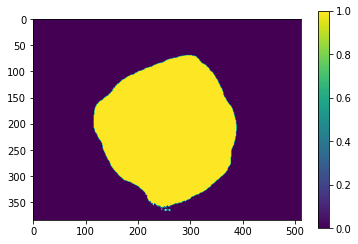

In [ ]:
plt.imshow(seg[batch_id])
plt.colorbar()

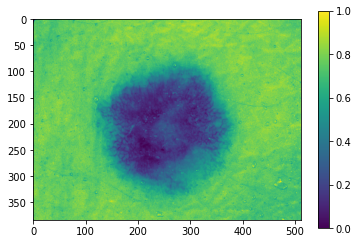

In [ ]:
plt.imshow(img[batch_id])
plt.colorbar()

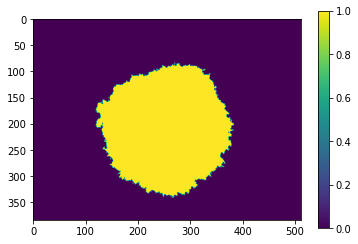

In [ ]:
plt.imshow(mask[batch_id])
plt.colorbar()

In [ ]:
inter = np.sum(seg[batch_id] * mask[batch_id])
union = np.sum(seg[batch_id]) + np.sum(mask[batch_id])
dice = (inter * 2) / union
print(dice)

0.9160099683437731
